In [17]:
import General.classes as classes
import General.functies as functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [34]:
def get_data_from_folder(mypath):
    """
    @in: het adres van een folder waaruit data getrokken wordt
    @out:   een lijst met namen van de files
            een datalijst: datalijst[experiment] = np.array([ [tijden (sec)],  [spannning CH1 (V)], [spanning CH2 (V)] ])
    
    """
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    datalijst = []

    for filenaam in onlyfiles:
        adres = mypath+'/'+filenaam
        file = open(adres, 'rt')
        data = file.read()
        file.close()
        data = data.replace(',','.') #ga naar deftige decimaalseparators
        inhoud = data.split('s	V	V')[1].split('\n')
        inhoudlijst = []
        #steek het in een lijst
        for regel in inhoud:
            if regel != '':
                lijst = regel.split('	')
                lijst = [float(elem) for elem in lijst]
                inhoudlijst.append(lijst.copy())
        inhoudlijst = np.array(inhoudlijst).T
        datalijst.append(inhoudlijst.copy())
    return onlyfiles, datalijst


def blokgolf(x, parameters): #een blokgolf met grootte G, frequentie f en offset x0, rond evenwichtspunt E
    f, G,  x0, E = parameters
    a = 2/f
    out = []
    for xval in x:
        xi = xval - x0
        periode = 1
        while not (periode-1)*a <= xi < periode*a:
            if xi < periode*a:
                periode -= 1
            else:
                periode += 1
        out.append(E + G*(-1)**periode)
    return np.array(out)

def sinus(x, parameters):
    A, k, phi, C = parameters
    return A*np.sin(k*x+phi)+C

def spanning_RLC(omega, parameters):
    V0, R, L, C = parameters
    spanning = V0*R/np.sqrt(R**2+(omega*L-1/(omega*C))**2)
    return spanning

def fase_RLC(omega, parameters):
    R, L, C = parameters
    fase = np.arctan((1-omega**2*L*C)/(omega*R*C)) #mijn uitwerking
    #fase = np.arctan(omega*R*C/(1-omega**2*L*C)) #Sam zijn uitwerking
    return fase

def fase_CR(omega, parameters):
    CR = parameters[0]
    fase = np.arctan(1/(omega*CR))
    return fase

def amplitude_CR(omega, parameters):
    CR, V0 = parameters
    amplitude = V0* omega*CR/np.sqrt(1+omega**2*CR**2)
    return amplitude
    
def constante(x, param):
    return param[0]

def output_RC_blokgolf(t, param):
    RC, V0, f, t0, E = param
    t -= t0 #shift nu al dan hoeven we er geen rekening meer mee te houden
    halveperiode = 2/(f)
    output = []
    for tijd in t: #bepaal in welke periode je zit. Niet te verwarren: halveperiode is de duur van 1 periode
        periode = 1
        while not (periode-1)*halveperiode <= tijd < periode*halveperiode:
            if tijd < periode*halveperiode:
                periode -= 1
            else:
                periode += 1
        tijdvak = periode
        tijdpriem = tijd - halveperiode*tijdvak

        if periode % 2 == 0: #in een even periode is het aan het opladen
            output.append(V0 * (1-np.exp((-tijdpriem)/RC)) + E)
        else: #in een oneven periode is het aan het ontladen
            output.append(V0 * (np.exp((-tijdpriem)/RC) * (np.exp(halveperiode/RC)-1)) + E)
    return np.array(output)

def fit_blokgolf(xvals, yvals, invalslist, limieten = None, plotting = False):
    #extraheer één periode:
    indxmin = 1
    while abs(yvals[indxmin-1] - yvals[indxmin]) < 1: #deze loop zorgt dat indxmin het eerste punt van een fase (hoog of laag) is
        indxmin += 1
    indxmax = indxmin
    while abs(yvals[indxmax+1] - yvals[indxmax]) < 1: #deze loop zorgt dat indxmax het laatste punt van een fase (hoog of laag) is
        indxmax += 1
    def invals_const(x,y):
        return yvals[indxmin]
    const1 = fix_enkelzijdige_fout(functies.fit(["C1"], constante, invals_const, xvals[indxmin:indxmax+1], yvals[indxmin:indxmax+1], y_err = np.full(indxmax+1-indxmin, 0.1)))[0]
    #extraheer een tweede periode:
    indxmin2 = indxmax + 1
    while abs(yvals[indxmin2-1] - yvals[indxmin2]) < 1: #deze loop zorgt dat indxmin het eerste punt van een fase (hoog of laag) is
        indxmin2 += 1
    indxmax2 = indxmin2
    while abs(yvals[indxmax2+1] - yvals[indxmax2]) < 1: #deze loop zorgt dat indxmax het laatste punt van een fase (hoog of laag) is
        indxmax2 += 1
    def invals_const(x,y):
        return yvals[indxmin2]
    const2 = fix_enkelzijdige_fout(functies.fit(["C2"], constante, invals_const, xvals[indxmin2:indxmax2+1], yvals[indxmin2:indxmax2+1], y_err = np.full(indxmax2+1-indxmin2, 0.1)))[0]

    E = [(const1[0] + const2[0])/2, np.sqrt(const1[1]**2 + const2[1]**2)/2, 'S']
    G = [abs(const1[0] - const2[0])/2, np.sqrt(const1[1]**2 + const2[1]**2)/2, 'S']
    f = [4/(xvals[indxmax2+1]- xvals[indxmin]), (xvals[2] - xvals[1]), 'S'] #de fout = de resolutie #waarom de factor 4? idk man het werkt gewoon
    if yvals[indxmin2] > yvals[indxmin]: #als C2 de top is en C1 de bottom:
        x_0 = [xvals[indxmin-1], (xvals[2] - xvals[1]), 'S']
    else:
        x_0 = [xvals[indxmin2-1], (xvals[2] - xvals[1]), 'S']
    
    outp = [f, G, x_0, E] #hell yeah blokgolf fit omzeilen go brrr
    #outp = functies.fit(["f",'G',"x_0",'E'], blokgolf, invals, xvals, yvals, initial_range=limieten, y_err = np.full(np.shape(yvals), 5), detailed_logs = False, minimizemethod='fuck you')
    parameterwaarden = [param[0] for param in outp]
    if plotting:
        fig, ax = plt.subplots(1,1,)
        Xval = np.linspace(0,5,1000)
        ax.scatter(xvals, yvals, linestyle = '',label = 'data')
        ax.plot(Xval, blokgolf(Xval, parameterwaarden), label = 'model')
        #ax.plot(Xval, blokgolf(Xval, invalslist), label = 'invals')
        plt.tight_layout()
        ax.legend()
        plt.show()

    return outp

def fit_sinus(xvals, yvals, yerr, freqgok = 1, plotting = False, detailed_logs = False):
    #bepaal initiele waarden
    maximum = max(yvals)
    minimum = min(yvals)
    amplitude = (maximum - minimum)/2
    C = (maximum + minimum)/2
    if yvals[0] <= yvals[1]:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.arcsin(yvals[0]/amplitude )
            C = 0
    else:
        if -1 <= (yvals[0] - C)/amplitude <= 1:
            phi = np.pi - np.arcsin( (yvals[0] - C)/amplitude )
        else:
            phi = np.pi - np.arcsin( yvals[0]/amplitude )
            C = 0

    def invals(x,y):
        return [amplitude, 2*np.pi*freqgok, phi, C]
    outp = functies.fit(['A','k','phi','C'], sinus, invals, xvals, yvals, y_err = yerr, detailed_logs=detailed_logs, fuck_CPU = True)
    plotparams = [elem[0] for elem in outp]
    if plotting:
        fig, ax = plt.subplots(1,1)
        ax.errorbar(xvals, yvals, yerr=yerr, linestyle = '', label = 'data')
        T = np.linspace(min(xvals),max(xvals),1000)
        ax.plot(T, sinus(T,plotparams),label = 'model')
        #ax.plot(T, sinus(T, invals(0,0)), label = 'invals')
        ax.legend()
        ax.set_xlabel('tijd (s)')
        ax.set_ylabel('spanning (mV of zo)')
        plt.tight_layout()
        plt.show()
    return outp

def fit_spanning_RLC(omegavals, yvals, omegaerr, yerr, title, invals = [1,1,1,1]):
    def initvals(x,y): #fix deze initial values
        return invals
    outp = functies.fit_2D(['V0', 'R', 'L', 'C'], spanning_RLC, initvals, omegavals, yvals, omegaerr, yerr, titel = title, x_as_titel='$\\omega$ [Hz]', y_as_titel = 'spanning [V]')
    return outp

def fit_fase_RLC(omegavals, fase, omegaerr, faseerr, title, invals = [1,1,1], bounds = None):
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['R', 'L', 'C'], fase_RLC, initvals, omegavals, fase, omegaerr, faseerr, bounds = bounds, titel = title, x_as_titel= '$\\omega$ [Hz]', y_as_titel = 'fase $\\phi$ [rad]')
    return outp

def fix_enkelzijdige_fout(outp):
    """
    @in: de output van een functies.fit
    @out: hetzelfde maar de fouten zijn geen tuples meer
    """
    for indx in range(len(outp)):
        if type(outp[indx][1]) == tuple:
            outp[indx][1] = (abs(outp[indx][1][0])+abs(outp[indx][1][1]))/2
    return outp

def plot_fase_RLC_gelineariseerd(omega, phi, omega_err, phi_err, params, xlim = None, ylim = None):
    """
    @in: is wel duidelijk denk ik 
    """
    R = params[0][0]
    L = params[1][0]
    C = params[2][0]
    omega = np.array(omega)
    omega_err = np.array(omega_err)
    phi = np.array(phi)
    phi_err = np.array(phi_err)
    tanphi = np.tan(phi)
    tanphi_err = phi_err/(np.cos(phi)**2)
    rechterlid = (1-omega**2*L*C)/(omega*R*C)
    rechterlid_err = np.abs((1+omega**2*L*C)/(omega**2*R*C)*omega_err)

    omegalinspace = np.linspace(0,max(omega),1000)
    tanphilinspace = (1-omegalinspace**2*L*C)/(omegalinspace*R*C)
    fig, ax = plt.subplots(1,1,figsize = (10,10))
    ax.set_title('gelineariseerde plot van de fase')
    ax.set_ylabel('tan($\\phi$)')
    ax.set_xlabel('$\\frac{-1+\\omega^2RC}{\\omega R C}$')
    ax.errorbar(rechterlid, tanphi, xerr=rechterlid_err, yerr=tanphi_err, linestyle = '', label = 'data')
    ax.plot(tanphilinspace,tanphilinspace,label = 'model')
    ax.legend()
    if not xlim is None:
        ax.set_xlim(xlim)
    if not ylim is None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    plt.show()

def fit_fase_CR(omegavals, fase, omegaerr, faseerr, invals):
    """
    @in: spreekt voor zich
    @out: het product C*R
    """
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['C * R'], fase_CR, initvals, omegavals, fase, omegaerr, faseerr, y_as_titel='faseverschil [rad]',x_as_titel='$\\omega$', titel = 'faseplot bij de CR-kring')
    return outp

def fit_amplitude_CR(omegavals, amplitude, omegaerr, amplitudeerr, invals):
    """
    @out: [[C*R en fout enzo], [V0 en fout enzo]]
    """
    def initvals(x,y):
        return invals
    outp = functies.fit_2D(['C*R','V0'], amplitude_CR, initvals, omegavals, amplitude, omegaerr, amplitudeerr,  y_as_titel='amplitude [V]',x_as_titel='$\\omega$', titel = 'amplitudelot bij de CR-kring')
    return outp


[[-4.650199204424198, -4.668280295873653]]
C1 heeft als waarde: -4.6593 + -0.0090218 - -0.0090593 met 68% betrouwbaarheidsinterval: [-4.6502, -4.6683] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.018928
[[6.0752953128152685, 6.093682907444389]]
C2 heeft als waarde: 6.0845 + 0.0091699 - 0.0092176 met 68% betrouwbaarheidsinterval: [6.0753, 6.0937] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.027319


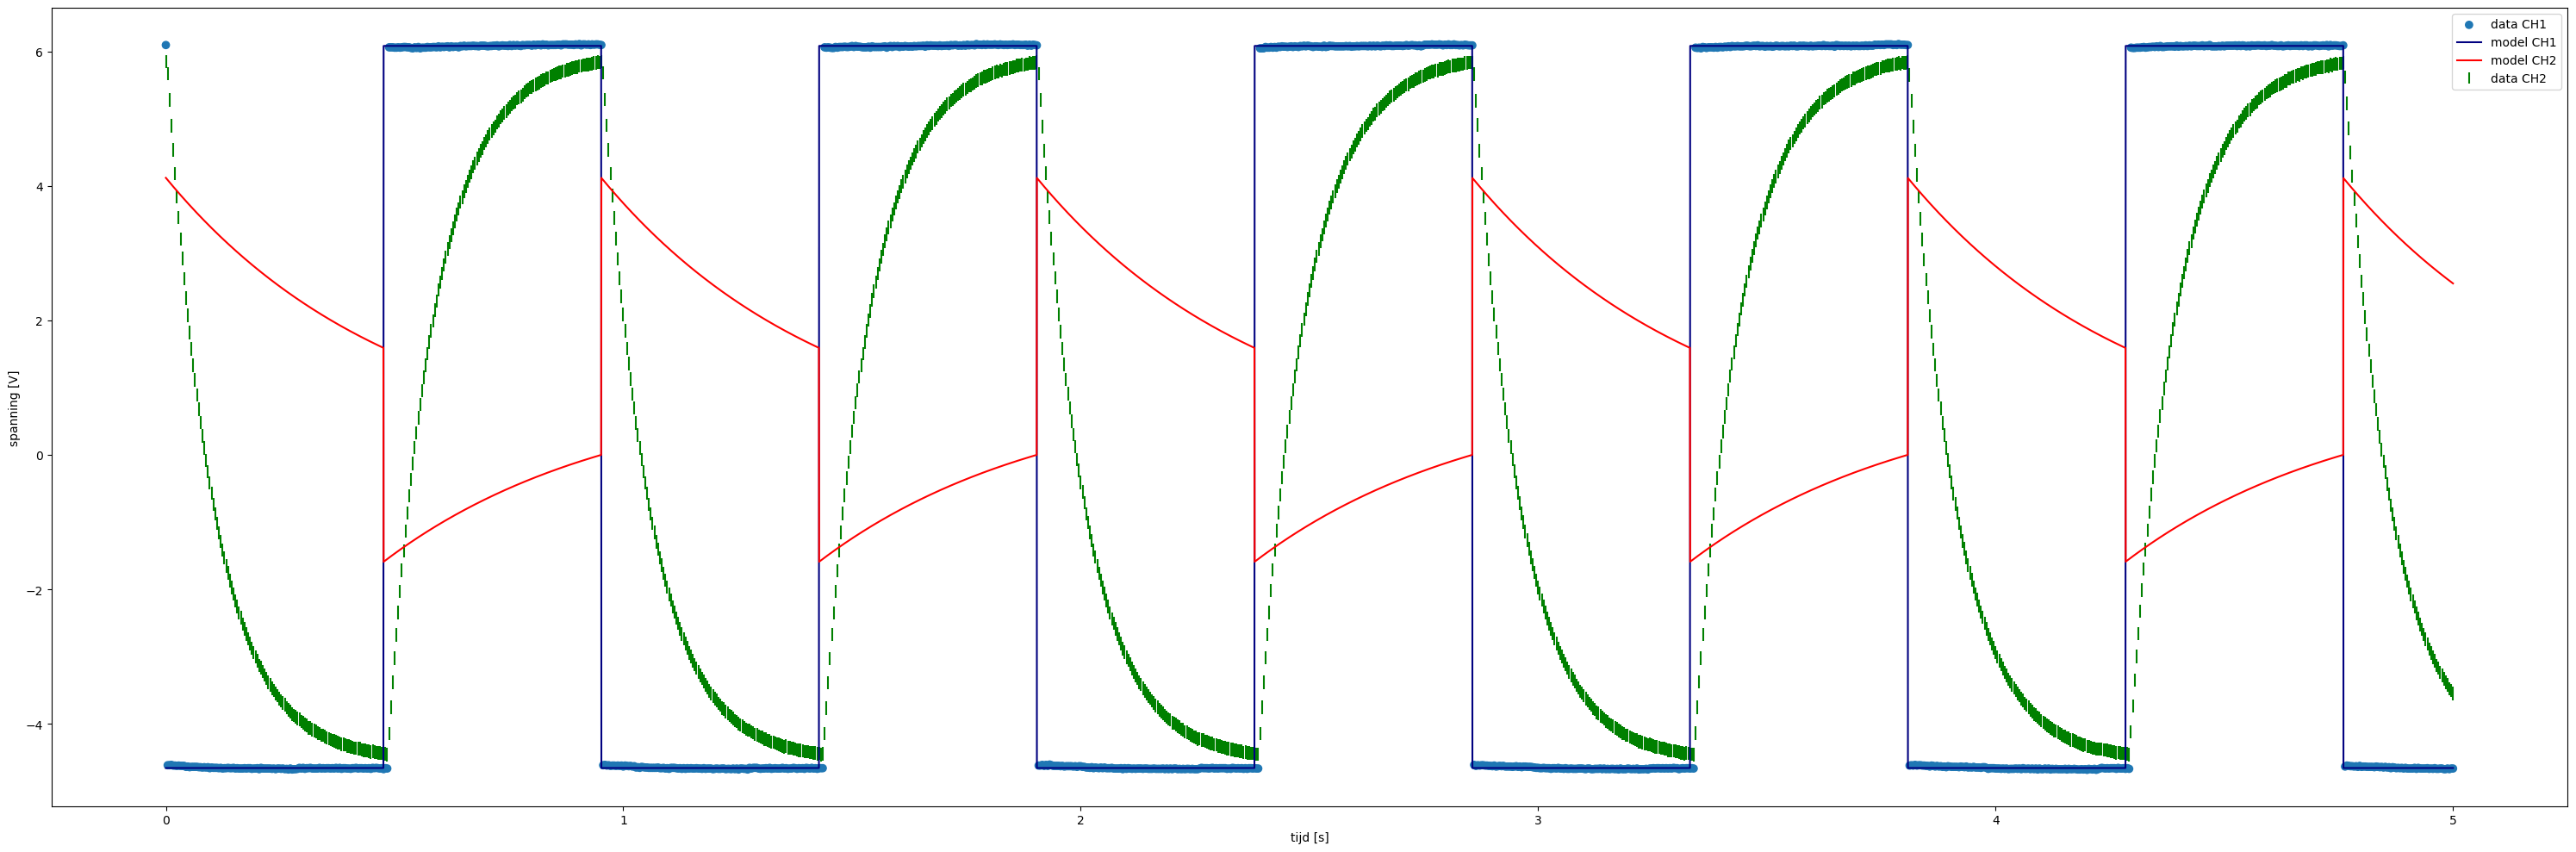

[[6.153932149714302, 6.165925770143298]]
C1 heeft als waarde: 6.1599 + 0.0059903 - 0.0060033 met 68% betrouwbaarheidsinterval: [6.1539, 6.1659] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.021644
[[-4.707814831813351, -4.719514470946447]]
C2 heeft als waarde: -4.7137 + -0.0058218 - -0.0058779 met 68% betrouwbaarheidsinterval: [-4.7078, -4.7195] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.021169


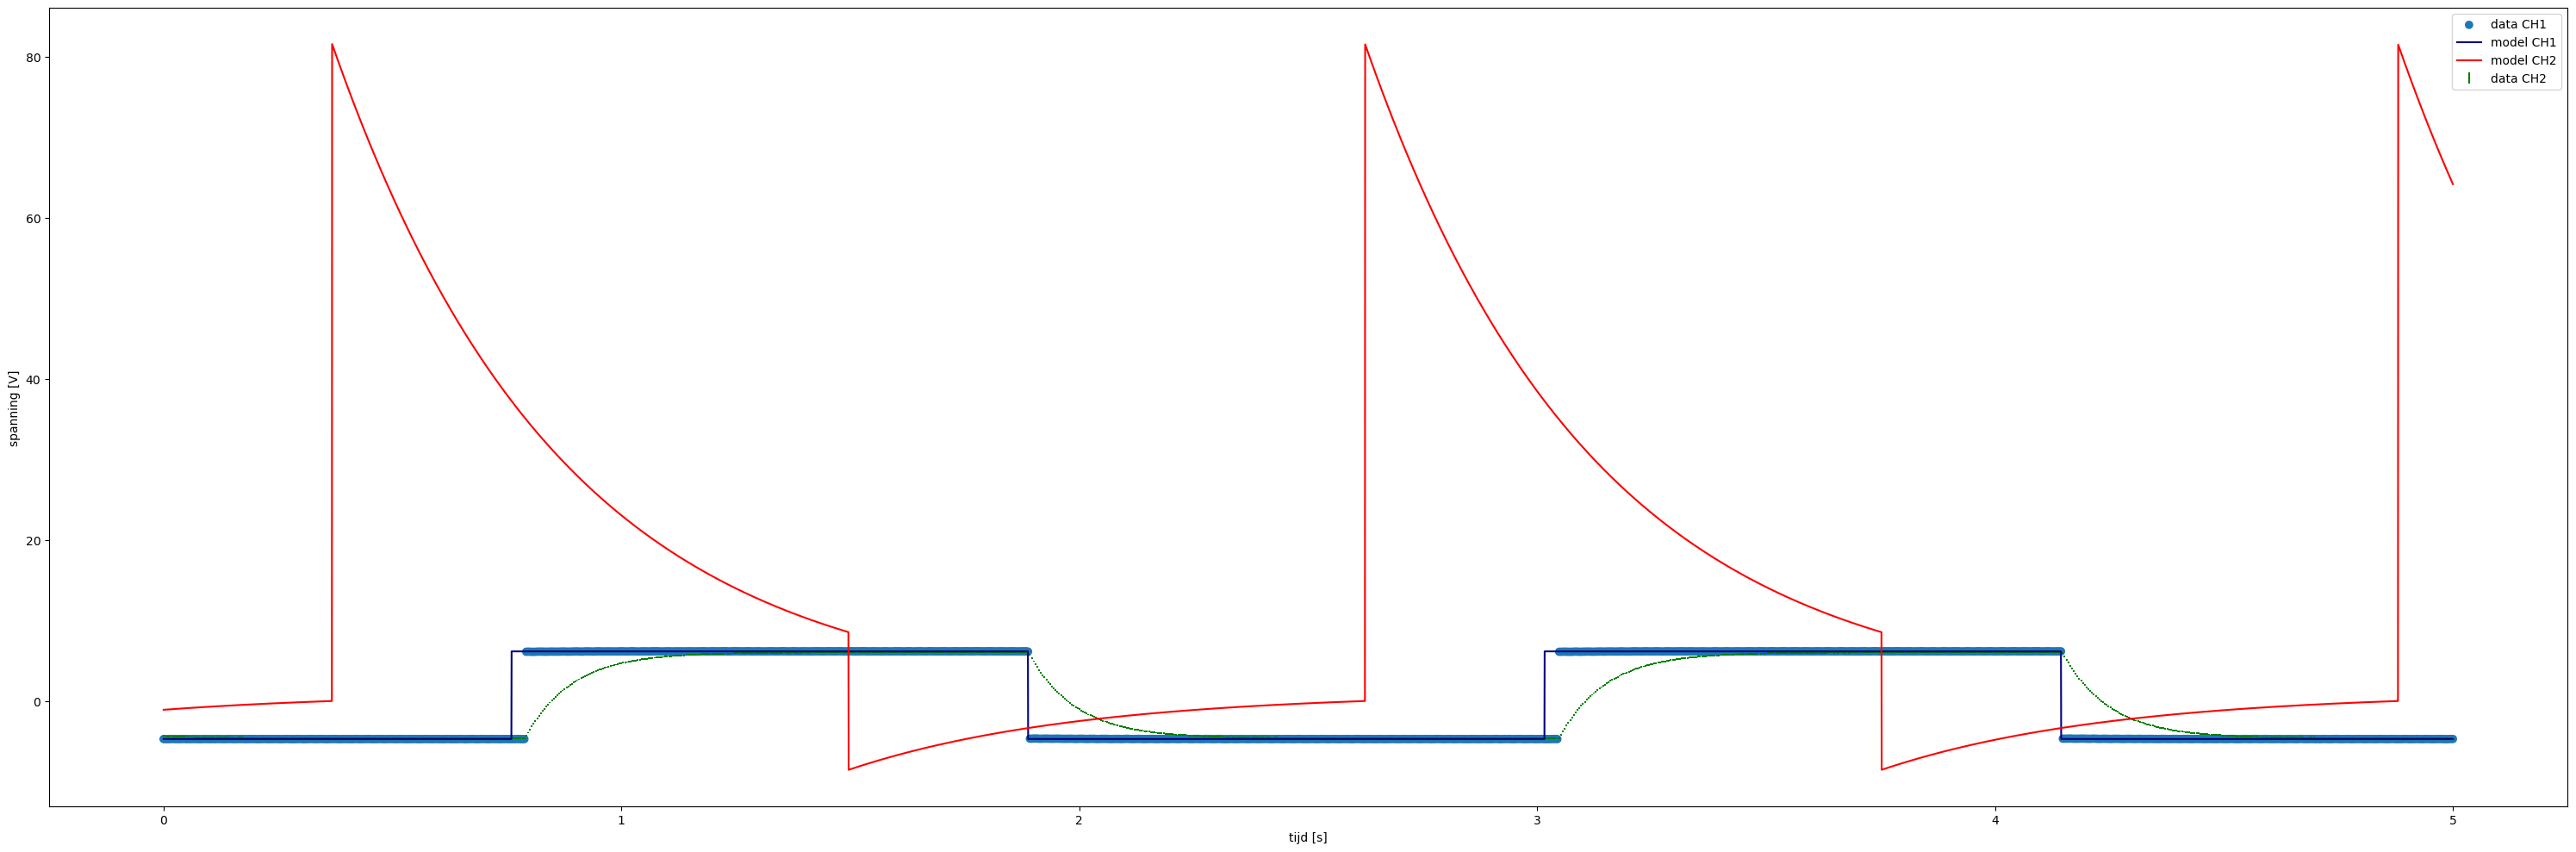

In [19]:
#kapot

mypath = "RLC proef/RC"
namen, datalijst = get_data_from_folder(mypath)
freqgoks = [4.2,2]  
verschuivingen = [0, 0]
limietlijst = [[(1,6), (5,7), (0,2),(-1,1)], None]
for indx in range(len(namen)):
    tijd = datalijst[indx][0]
    CH1 = datalijst[indx][1]
    CH2 = datalijst[indx][2]
    top = max(CH1)
    bot = min(CH1)
    invalslist = [freqgoks[indx], (top-bot)/2, verschuivingen[indx], (top+bot)/2]
    outp = fit_blokgolf(tijd, CH1, invalslist, limieten = limietlijst[indx], plotting=False)
    f, G, x_0, E = outp
    parameterwaarden_CH1 = [f[0], G[0], x_0[0], E[0]]
    if True: #zet op True om te plotten
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(tijd, CH2, yerr = np.full(np.shape(CH2),0.1), linestyle = '', color = 'green', label = 'data CH2')
        Xval = np.linspace(0,5,10000)
        ax.scatter(tijd, CH1, linestyle = '',label = 'data CH1')
        ax.plot(Xval, blokgolf(Xval, parameterwaarden_CH1), color = 'navy', label = 'model CH1')
        ax.plot(Xval, output_RC_blokgolf(Xval+x_0[0], [10e3*5e-5, 1, f[0], 0, 0]), color = 'red',label = 'model CH2')
        ax.legend()
        ax.set_xlabel('tijd [s]')
        ax.set_ylabel('spanning [V]')
        plt.tight_layout()
        plt.show()

In [ ]:
mypath = "RLC proef/CR"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('CRkring - freq','').replace('.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
fit_fase_CR(input_f*2*np.pi,fase, input_f_fout*2*np.pi, fasefout, [10e3 * 5e-6])
fit_amplitude_CR(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout, [10e3 * 5e-6, 6])
"""
#de faseplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()"""

input bij freq 100.0
[[5.740903564288492, 5.779944708288492], [642.8551124230597, 643.0881671910598], [2.2897472612798193, 2.2966018132798194], [0.49054417858948784, 0.5179623865894879]]
A heeft als waarde: 5.7604 + 0.019521 - 0.019521 met 68% betrouwbaarheidsinterval: [5.7409, 5.7799] 
k heeft als waarde: 642.97 + 0.11653 - 0.11653 met 68% betrouwbaarheidsinterval: [642.86, 643.09] 
phi heeft als waarde: 2.2932 + 0.0034273 - 0.0034273 met 68% betrouwbaarheidsinterval: [2.2897, 2.2966] 
C heeft als waarde: 0.50425 + 0.013709 - 0.013709 met 68% betrouwbaarheidsinterval: [0.49054, 0.51796] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.06048
output bij freq 100.0
[[5.719780158099236, 5.7588213020992365], [642.8533219614225, 643.0862277174225], [2.373248022147317, 2.380102574147317], [-0.02732771569382817, 9.049230617182852e-05]]
A heeft als waarde: 5.7393 + 0.019521 - 0.019521 met 68% betrouwbaarheidsinterval: [5.7198

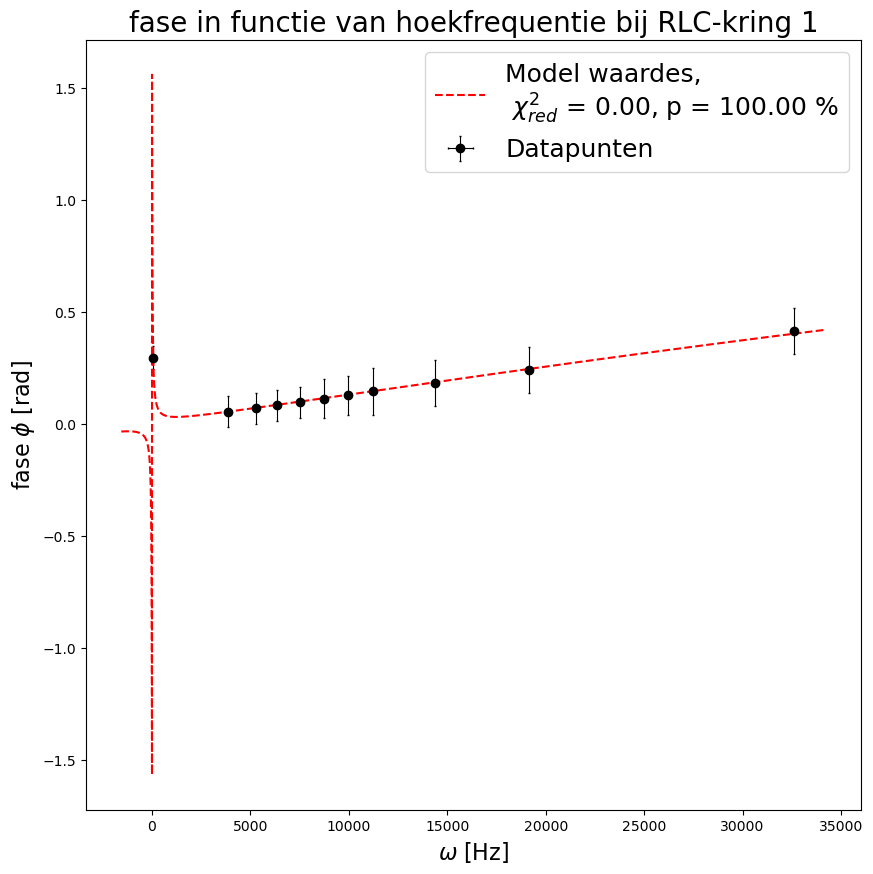

TypeError: fit_spanning_RLC() got an unexpected keyword argument 'bounds'

In [40]:
mypath = "RLC proef/RLC1"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('RLCkring - ','').replace('Hz.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    #dus basically: de code fit insane goed, maar het duurt wel een volle minuut
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
print('GEFIT:')
outp_fase = fit_fase_RLC(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout,'fase in functie van hoekfrequentie bij RLC-kring 1', invals = [10e3, 4*2.2e-3, 5*10e-6])#, bounds = [(1e3,1e5), (1e-3,2e-2),(0,1e-4)])
#plot_fase_RLC_gelineariseerd(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, [[10e3], [4*2.2e-3], [5*10e-6]])
print(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,'amplitude in functie van hoekfrequentie bij RLC-kring 1',
                       invals = [max(amplitude), 10e3, 4*2.2e-3, 5*10e-6], bounds = [(0,10), (1e3,1e5), (1e-3,2e-2),(0,1e-4)]))

#de faseplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()

input bij freq 100.0
[[4.1894182344863165, 4.228161354486316], [652.8415769332637, 653.1626977932636], [-1.5130086694762714, -1.5037699254762713], [0.49705038285690717, 0.5244685908569072]]
A heeft als waarde: 4.2088 + 0.019372 - 0.019372 met 68% betrouwbaarheidsinterval: [4.1894, 4.2282] 
k heeft als waarde: 653 + 0.16049 - 0.16063 met 68% betrouwbaarheidsinterval: [652.84, 653.16] 
phi heeft als waarde: -1.5084 + 0.0046194 - 0.0046194 met 68% betrouwbaarheidsinterval: [-1.513, -1.5038] 
C heeft als waarde: 0.51076 + 0.013709 - 0.013709 met 68% betrouwbaarheidsinterval: [0.49705, 0.52447] 
De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 1
De gereduceerde chi^2 waarde is: 0.025349
output bij freq 100.0
[[3.101136752258132, 3.1401778962581317], [652.7821992596713, 653.2100127116713], [-1.2519848747313655, -1.2394678667313654], [-0.030308727292152376, -0.0028905192921523763]]
A heeft als waarde: 3.1207 + 0.019521 - 0.019521 met 68% betrouwbaarheidsinterval

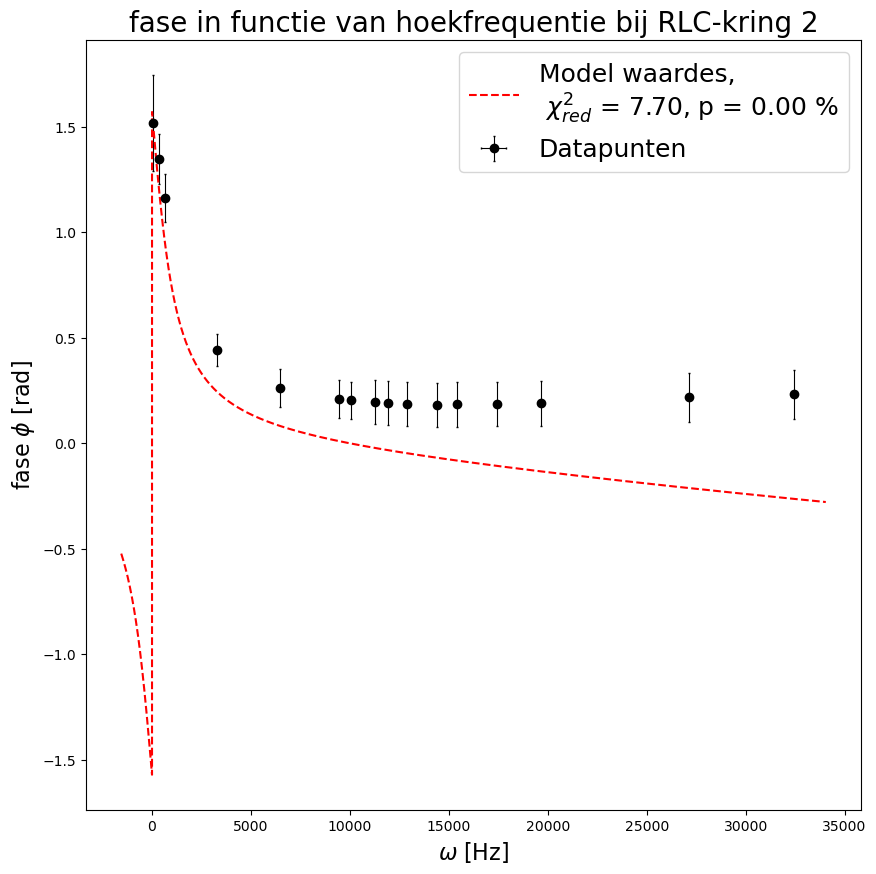

'\nprint(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,\'amplitude in functie van hoekfrequentie bij RLC-kring 2\', invals = [max(amplitude), 100, 4*2.2e-3, 5*10e-6]))\nfig, ax = plt.subplots(1,1)\nax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = \'gemeten\', linestyle = \'\', marker = \'o\')\nax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")\nax.set_ylabel(\'het faseverschil tussen de in- en output [radialen]\')\nax.legend()\nplt.tight_layout()\nplt.show()\n#de amplitudeplot\nfig, ax = plt.subplots(1,1)\nax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = \'gemeten\', linestyle = \'\', marker = \'o\')\nax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")\nax.set_ylabel(\'de amplitude van het outputsignaal [V]\')\nax.legend()\nplt.tight_layout()\nplt.show()'

In [ ]:
mypath = "RLC proef/RLC2"
namen, datalijst = get_data_from_folder(mypath)

fase = [] #het faseverschil tussen het in-en outputsignaal
fasefout = []

input_f = [] #frequentie (!= hoekfrequentie) van het inputsignaal
input_f_fout = []

amplitude = [] #de amplitude van het outputsignaal
amplitudefout = []
for indx in range(len(datalijst)):
    freqgok = float(namen[indx].replace('RLC2 - ','').replace('Hz.txt',''))
    dataset = datalijst[indx]
    tijden, CH1, CH2 = dataset
    print('input bij freq', freqgok)
    inputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH1, np.full(np.shape(CH1), 0.1),freqgok = freqgok, plotting = False, detailed_logs=False))
    print('output bij freq', freqgok)
    outputsinus = fix_enkelzijdige_fout(fit_sinus(tijden, CH2, np.full(np.shape(CH2), 0.1), freqgok = freqgok, plotting = False, detailed_logs=False))
    #de fits zijn insane ze duren wederom een volle minuut tho
    hoek = outputsinus[2][0] - inputsinus[2][0]
    hoekfout = np.sqrt(outputsinus[2][1]**2+inputsinus[2][1]**2)
    while -np.pi > hoek:
        hoek += 2*np.pi
    while hoek > np.pi:
        hoek -= 2*np.pi
    fase.append(hoek)
    fasefout.append(hoekfout)
    input_f.append(inputsinus[1][0]/2*np.pi)
    input_f_fout.append(inputsinus[1][1]/2*np.pi)
    amplitude.append(outputsinus[0][0])
    amplitudefout.append(outputsinus[0][1])
input_f = np.array(input_f)
input_f_fout = np.array(input_f_fout)
#de faseplot
print('GEFIT:')
outp = fit_fase_RLC(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout,'fase in functie van hoekfrequentie bij RLC-kring 2', invals = [100, 4*2.2e-3, 5*10e-6], bounds = [(10,1000),(1e-3,2e-2),(10e-6,1e-4)])
#plot_fase_RLC_gelineariseerd(input_f*2*np.pi, fase, input_f_fout*2*np.pi, fasefout, outp, xlim = (0,20))
print(fit_spanning_RLC(input_f*2*np.pi, amplitude, input_f_fout*2*np.pi, amplitudefout,'amplitude in functie van hoekfrequentie bij RLC-kring 2', invals = [max(amplitude), 100, 4*2.2e-3, 5*10e-6]))
"""
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, fase, xerr = input_f_fout, yerr = fasefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('het faseverschil tussen de in- en output [radialen]')
ax.legend()
plt.tight_layout()
plt.show()
#de amplitudeplot
fig, ax = plt.subplots(1,1)
ax.errorbar(input_f, amplitude, xerr = input_f_fout, yerr = amplitudefout, label = 'gemeten', linestyle = '', marker = 'o')
ax.set_xlabel("frequentie f van het inkomende signaal [Hz denk ik]")
ax.set_ylabel('de amplitude van het outputsignaal [V]')
ax.legend()
plt.tight_layout()
plt.show()"""